# Gutenberg N-Grams

Start the Spark Context: 

In [1]:
import sys, os
os.environ['SPARK_DRIVER_MEMORY'] = '8g'

import pyspark
from pyspark import SparkConf, SparkContext

In [2]:
conf = SparkConf()

In [3]:
num_execs = 10
exec_cores = 4

In [4]:
conf.set('spark.executor.memory', '8g')
conf.set('spark.executor.instances', str(num_execs))
conf.set('spark.executor.cores', str(exec_cores))
conf.set('spark.executorEnv.PYTHONPATH', 
         '/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip:/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/:/cluster/home03/sdid/roskarr/spark_workshop')

conf.set('spark.driver.memory', '8g')

In [6]:
sc = pyspark.SparkContext(master = 'yarn-client', conf = conf)

## Make a key-value RDD of book metadata and text

Getting data into spark from a collection of local files is a very common task. A useful pattern to keep in mind is the following: 

1. make a list of filenames and distribute it among the workers
3. "map" each filename to the data you want to get out
4. now you are left with the RDD of raw data distributed among the workers!

The [`gutenberg_cleanup`](gutenberg_cleanup.py) module contains two functions that can help with this: `get_text` and `get_metadata`.

They pretty much do the obvious: 

`get_metadata` returns a metadata object with various useful fields that will be used to create a unique key for each book

`get_text` returns the raw text extracted from HTML, cleaned of tags and punctuation and converted to lower case. 

### 1. Distributing the filenames

In [7]:
import glob
flist = glob.glob('/cluster/home03/sdid/roskarr/work/gutenberg/html/*html')
print 'number of books: ', len(flist)

number of books:  5530


In [8]:
files_rdd = sc.parallelize(flist, 200)

In [9]:
files_rdd.take(5)

['/cluster/home03/sdid/roskarr/work/gutenberg/html/1000.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1001.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1002.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1003.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1004.html']

### 2. Map the filenames to metadata, text key-value pairs

Use the `get_text` and `get_metadata` functions to construct a key,value pair RDD, where `key` is the dictionary returned by `get_metadata`. For the `value` of each `key`,`value` pair use the raw text returned by `get_text`. 

Hint: in Python, there are many ways to make a string, but a pretty easy one is like this: 

    "bla_%s"%(var)"

where `var` matches the `%s` and is a variable that can be converted to a string. You can include more `%s` (or `%d`, `%f` etc) and more variables in the tuple that follows. 

In [13]:
import gutenberg_cleanup
reload(gutenberg_cleanup)
from gutenberg_cleanup import get_metadata, get_text, get_gid

In [14]:
text_rdd = (files_rdd.map(lambda filename: 
                        (get_metadata(get_gid(filename)), get_text(filename))))

So that we don't have to constantly re-load the data off disk, lets cache this RDD: 

In [16]:
text_rdd.cache()
text_rdd.count()

5530

Take a look at the first set of keys:

In [17]:
text_rdd.keys().take(10)

[{'birth_year': None,
  'death_year': None,
  'first_name': None,
  'gid': 1000,
  'last_name': None,
  'title': '- No Title -'},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'first_name': None,
  'gid': 1001,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Hell"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'first_name': None,
  'gid': 1002,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Purgatory"},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'first_name': None,
  'gid': 1003,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Paradise"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'first_name': None,
  'gid': 1004,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Complete"},
 {'birth_year': u'1772',
  'death_year': u'1844',
  'first_name': None,
  'gid': 1005,
  'last_name': u'Dante Alighieri',

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all elements that lack a value for `title`, `first_name`, `last_name`, or `birth_year`.

In [18]:
filtered_rdd = (files_rdd.map(lambda filename: (filename, get_metadata(get_gid(filename))))
                         .filter(lambda (filename,meta): all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])))

In [19]:
filtered_rdd.take(10)

[('/cluster/home03/sdid/roskarr/work/gutenberg/html/101.html',
  {'birth_year': u'1954',
   'death_year': None,
   'first_name': u'Bruce',
   'gid': 101,
   'last_name': u'Sterling',
   'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}),
 ('/cluster/home03/sdid/roskarr/work/gutenberg/html/1013.html',
  {'birth_year': u'1866',
   'death_year': u'1946',
   'first_name': u'H. G. (Herbert George)',
   'gid': 1013,
   'last_name': u'Wells',
   'title': u'The First Men in the Moon'}),
 ('/cluster/home03/sdid/roskarr/work/gutenberg/html/1014.html',
  {'birth_year': u'1874',
   'death_year': u'1940',
   'first_name': u'B. M.',
   'gid': 1014,
   'last_name': u'Bower',
   'title': u'The Lure of the Dim Trails'}),
 ('/cluster/home03/sdid/roskarr/work/gutenberg/html/1015.html',
  {'birth_year': u'1823',
   'death_year': u'1893',
   'first_name': u'Francis',
   'gid': 1015,
   'last_name': u'Parkman',
   'title': u'The Oregon Trail: Sketches of Prairie and Rocky-Mounta

How many do we have left? 

In [20]:
print 'number of books after filtering: ', filtered_rdd.count()

number of books after filtering:  4883


Some of the books end up in multiple files, but they should all have the same gid. 

To check for this we will use one of the most basic and common Map/Reduce patterns: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. 
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

In [21]:
from operator import add

In [22]:
(filtered_rdd.map(lambda (filename, meta): (meta['gid'], 1))
             .reduceByKey(add)
             .sortBy(lambda (key,count): count, False)
             .take(20))

[(6478, 43),
 (3772, 40),
 (3332, 33),
 (3425, 23),
 (2440, 16),
 (6475, 15),
 (4022, 5),
 (1079, 2),
 (2401, 1),
 (2601, 1),
 (5601, 1),
 (4201, 1),
 (3801, 1),
 (6401, 1),
 (4401, 1),
 (1201, 1),
 (5001, 1),
 (6801, 1),
 (3601, 1),
 (6201, 1)]

Looks like we have a few that are made up of multiple sections. To combine them, we will use `groupByKey` (see warning below) which will result in having an RDD of `gid`'s as keys and lists of filenames for each `gid`. Once we have the lists combined, we will do another `map` to read the actual text. Note that doing this is much cheaper than reading the text first and then combining (if we had used the `text_rdd` from the top of the notebook, for example) because we are only sending around file names rather than all the document data. 

** warning about `groupByKey` **: this is in general the most expensive of the grouping/accumulating operations because it sends the entire RDD across the network in order to group the values in a list. No local aggregation happens on the partitions. By contrast, `reduceByKey` and `aggregateByKey` do the reductions/aggregations *localy* on each partition first and only then shuffle the data around, resulting in much less traffic. However, since we actually aren't sending much data here and since we only have a few elements that need to be grouped, it's fine to use it for simplicity's sake. In general, however, `groupByKey` likes to cause memory problems and runs very slowly. 

So, the procedure for doing this final step of pre-processing: 

1. `map` the `filtered_rdd` to have the `gid` as a key and `filename` as the value
2. do `groupByKey`
3. `map` the resulting (`gid`,`flist`) key value pair RDD to yield a (`gid`, `<combined text>`) RDD

*hint*: the `join` function in the `string` module can combine a list of strings efficiently. 
*hint2*: `groupByKey` will give you an *iterable* of filenames as a result -- you can use it inside a list comprehension with the `get_text` function 

In [25]:
import string
cleaned_rdd = (filtered_rdd.map(lambda (filename, meta): (meta['gid'], filename))
                           .groupByKey()
                           .map(lambda (gid,flist): (gid,string.join([get_text(f) for f in flist]))))

In [26]:
cleaned_rdd.cache().count()

4714

## Processing the data

We're finished with the pre-processing. `cleaned_rdd` contains `gid`'s as keys and text as values. If we want some other piece of metadata, we can just call the `get_metadata` function inside a `map` to extract it. 

### Histogram of book years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + 30\right)$. 

This means that for authors that are still living, we assume they wrote their book at 30.  

In [27]:
def publication_year(meta) : 
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        return int(meta['birth_year']) + 30
    else :
        death_year = int(meta['death_year'])
        return max((birth_year + death_year) / 2.0, birth_year+30)

In [28]:
year_rdd = cleaned_rdd.map(lambda (gid, text): publication_year(get_metadata(gid)))

The histogram function actually already exists in the Spark API (but it didn't use to!). However, for fun we will write our own. Calculating the histogram can be split up into two parts. First, we need to figure out which bin each value corresponds to: 

1. take bins and a value as input
2. calculate the bin that the value maps to and return (`bin`, 1) pair

Second, we need to do a simple `reduceByKey` where we just add up all the values belonging to each bin. 

In [29]:
from bisect import bisect_right
import numpy as np
def get_bin(bin_edges, value) : 
    return bisect_right(bin_edges, value) - 1

In [43]:
def histogram(rdd, nbins = 100, min_val=None, max_val=None) :
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min()
    if max_val is None : 
        max_val = rdd.max()
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    binned_rdd = rdd.map(lambda x: get_bin(bin_edges, x))
    
    res = binned_rdd.countByValue()
    
    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in res.iteritems() : 
        if item[0] > len(res_full)-1 : overflow += item[1]
        else: res_full[item[0]] = item[1]
    res_full[-1] += overflow
    
    return .5*(bin_edges[:-1]+bin_edges[1:]), res_full

In [48]:
res = histogram(year_rdd, min_val = 1600)

In [49]:
res

(array([ 1602.005,  1606.015,  1610.025,  1614.035,  1618.045,  1622.055,
         1626.065,  1630.075,  1634.085,  1638.095,  1642.105,  1646.115,
         1650.125,  1654.135,  1658.145,  1662.155,  1666.165,  1670.175,
         1674.185,  1678.195,  1682.205,  1686.215,  1690.225,  1694.235,
         1698.245,  1702.255,  1706.265,  1710.275,  1714.285,  1718.295,
         1722.305,  1726.315,  1730.325,  1734.335,  1738.345,  1742.355,
         1746.365,  1750.375,  1754.385,  1758.395,  1762.405,  1766.415,
         1770.425,  1774.435,  1778.445,  1782.455,  1786.465,  1790.475,
         1794.485,  1798.495,  1802.505,  1806.515,  1810.525,  1814.535,
         1818.545,  1822.555,  1826.565,  1830.575,  1834.585,  1838.595,
         1842.605,  1846.615,  1850.625,  1854.635,  1858.645,  1862.655,
         1866.665,  1870.675,  1874.685,  1878.695,  1882.705,  1886.715,
         1890.725,  1894.735,  1898.745,  1902.755,  1906.765,  1910.775,
         1914.785,  1918.795,  1922.80

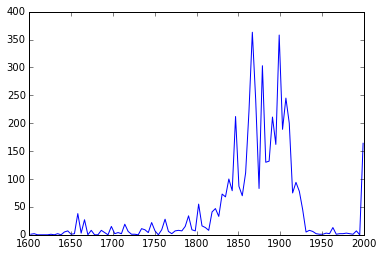

In [52]:
plt.plot(res[0], res[1])

In [ ]:
# First figure out which bin each document falls into: 
    binned = rdd.map(lambda (_,x): get_bins(len(x),binedges))

    # Then add up all the bins: 
    res = binned.countByValue()

    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in res.iteritems() : 
        if item[0] > len(res_full)-1 : overflow += item[1]
        else: res_full[item[0]] = item[1]
    res_full[-1] += overflow
    
    return bins, res_full
